# EEG Data interpretation -  Meditation and Individual Alpha Frequency (iAF)

This notebook processes EEG data of subjects that participated in the following experimental protocol:

Baseline blocks
	1.	Eyes Open (EO) – 2 minutes
	2.	Eyes Closed (EC) – 2 minutes

Task blocks
	3.	No music + finger tapping – 2 minutes
	4.	Break – 1 minute
	5.	Music (rock or classical) + finger tapping – 2 minutes
	6.	Break – 1 minute

Meditation
	7.	Meditation – 10 minutes

Post-meditation baseline
	8.	Eyes Closed (EC) – 2 minutes

The scope of the experiment is to compare the changes in alpha and theta frequencies, and their ratio (iAF) across the baseline, meditation, and post meditation, between-subjects. 

## Preprocessing Pipeline:
1. Notch filtering (50, 100 Hz) - Remove line noise
2. Bandpass filtering (1-40 Hz) - Keep relevant frequency bands
3. ICA - Remove artifacts (eye blinks, muscle activity)
4. Epoching - Segment data around events (TODO)
5. Power analysis - Extract alpha/theta power (TODO)


## 1. Import Libraries and Setup


In [2]:
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from pathlib import Path

# inline plotting
%matplotlib inline

# get the directory where this notebook is located
script_dir = Path.cwd()

## 2. Load EEG Data


In [3]:
raw_data = mne.io.read_raw_brainvision(
        script_dir / "data/first_collection_lab/classical_A_M_2025-12-15_15-04-18.vhdr",
        preload=True
    )

Extracting parameters from c:\Users\bicle\Desktop\project-eeg\EEG\eeg-project\data\first_collection_lab\classical_A_M_2025-12-15_15-04-18.vhdr...


Setting channel info structure...
Reading 0 ... 651019  =      0.000 ...  1302.038 secs...


C:\Users\bicle\AppData\Local\Temp\ipykernel_20332\2440419030.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_brainvision(


In [5]:
# 'standard_1020' - standard 10-20 system positions
montage = mne.channels.make_standard_montage('standard_1020')
raw_data.set_montage(montage, match_case=False, on_missing='ignore')

<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

## 3. Visualize Raw Data


In [8]:
# plot raw data
raw_data.plot(duration=10.0, n_channels=22, scalings='auto', title='Classical Music - Raw Data')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


C:\Users\bicle\AppData\Local\Temp\ipykernel_20332\1153460182.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


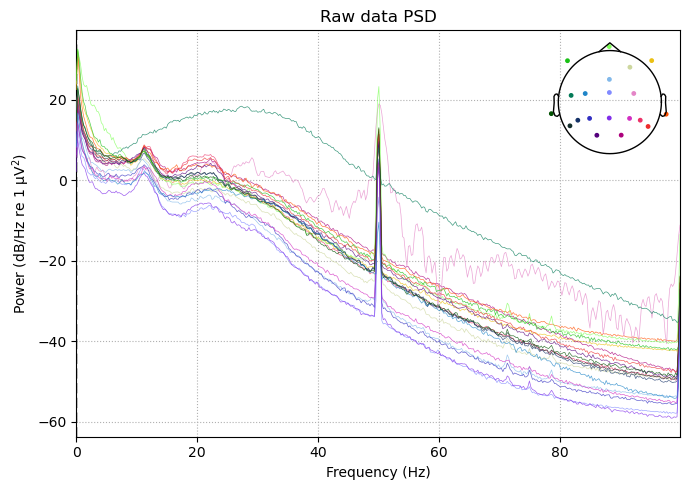

In [12]:
# power spectral density of raw data
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

raw_data.plot_psd(fmax=100, ax=ax, show=False)
ax.set_title('Raw data PSD')

plt.tight_layout()
plt.show()


## 4. Preprocessing Pipeline


### 4.1 Notch Filtering (Remove Line Noise)


In [15]:
# copy for preprocessing
raw_data_filtered = raw_data.copy()

# 50 and 100 Hz notch filters
raw_data_filtered.notch_filter([50, 100])


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

### 4.2 Bandpass Filtering (Keep 1-40 Hz)


In [16]:
# bandpass filter - 1-40 hz
raw_data_filtered.filter(l_freq=1, h_freq=40)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)


<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


C:\Users\bicle\AppData\Local\Temp\ipykernel_20332\3007776348.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


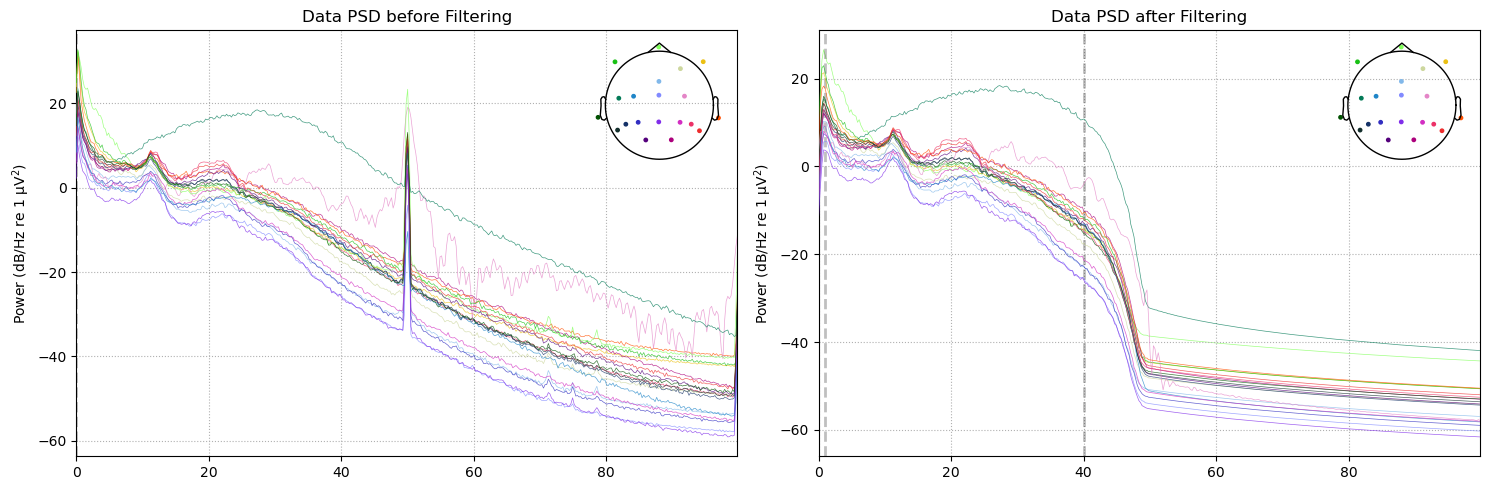

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# data psd before 
raw_data.plot_psd(fmax=100, ax=axes[0], show=False)
axes[0].set_title('Data PSD before Filtering')

# data psd adfter
raw_data_filtered.plot_psd(fmax=100, ax=axes[1], show=False)
axes[1].set_title('Data PSD after Filtering')
plt.tight_layout()
plt.show()


### 4.3 ICA - Independent Component Analysis (Remove Artifacts)


Fitting ICA to data using 20 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 99.0s.


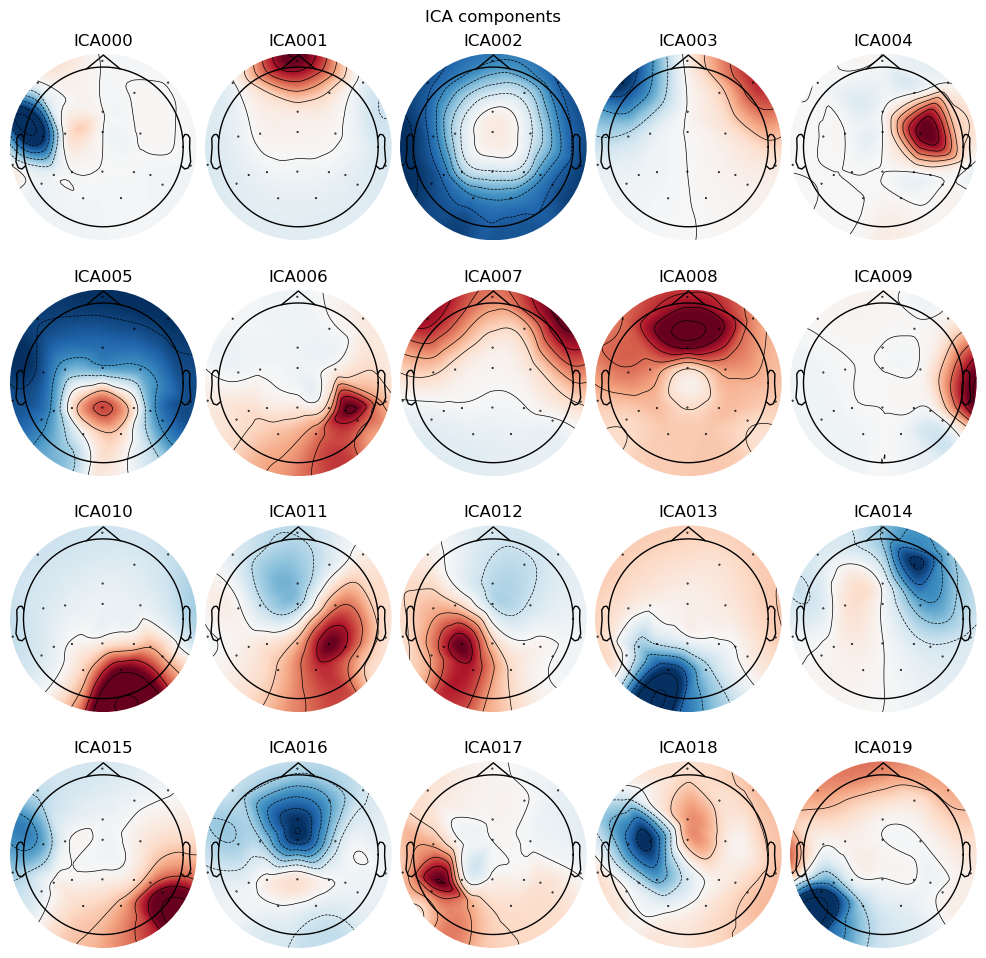

In [33]:
# fit ica on filtered data
ica_data = ICA(n_components=20, random_state=97, max_iter='auto')
ica_data.fit(raw_data_filtered)

# show ica components
fig = ica_data.plot_components()

# TODO: find artifacts to exclude in the next step

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated


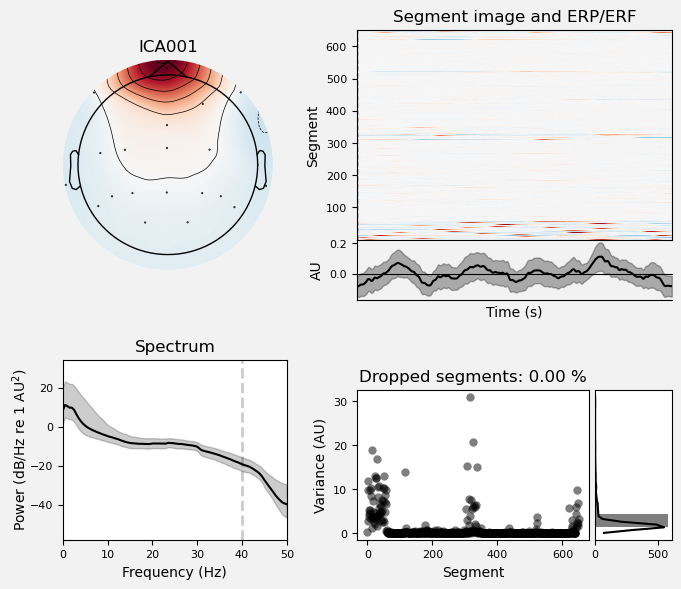

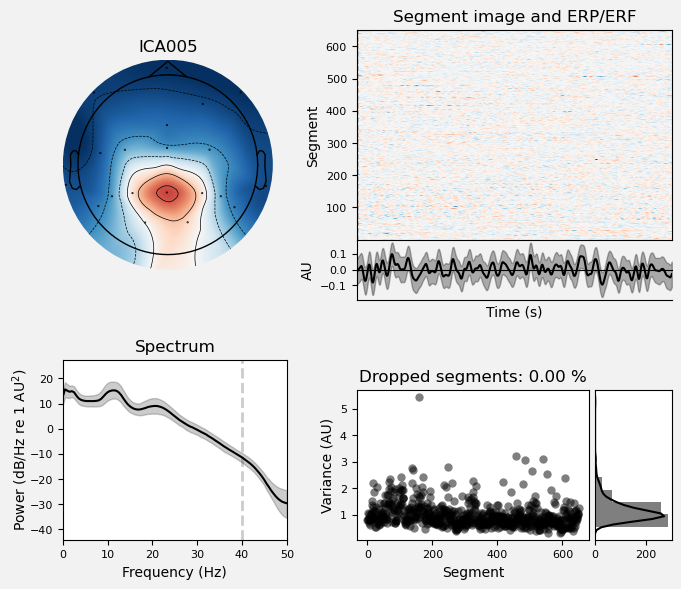

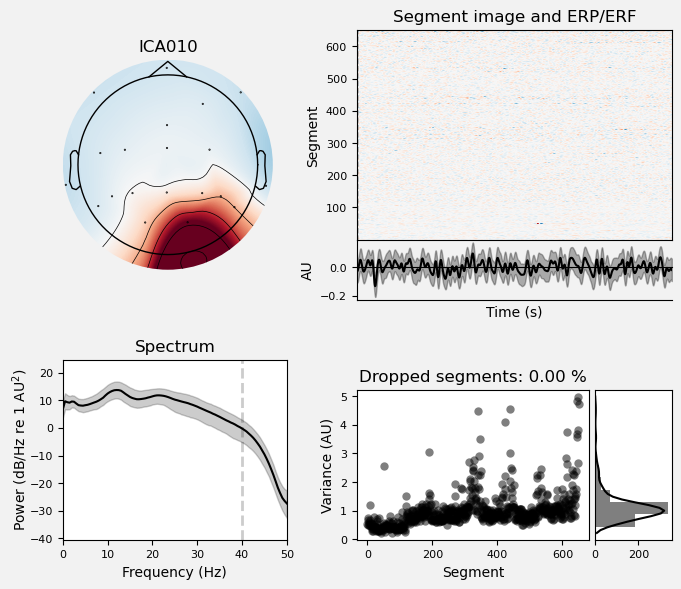

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [ ]:
# ICA component properties - helps you find artifacts
# look for
# - activity frontal channels - eye blinks
# - activity temporal channels - muscle artifacts
# - unusual frequency content
ica_data.plot_properties(raw_data_filtered, picks=[1,2,3,8]) # change picks as needed


### 4.4 Apply ICA (Remove Artifacts)

**!!! IMPORTANT !!!** Before running this cell, you should:
1. Inspect the ICA components
2. Identify rtifacts
3. Set `ica.exclude`


In [37]:
ica_data.exclude = [1,2,3,8]  # indexes of excluded components

# apply ICA
raw_data_clean = ica_data.apply(raw_data_filtered.copy())


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 20 PCA components


## 5. Visualize Cleaned Data


In [40]:
# plot clean data
raw_data_clean.plot(duration=10.0, n_channels=22, scalings='auto', 
                        title='Cleaned Data')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


C:\Users\bicle\AppData\Local\Temp\ipykernel_20332\4164960763.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


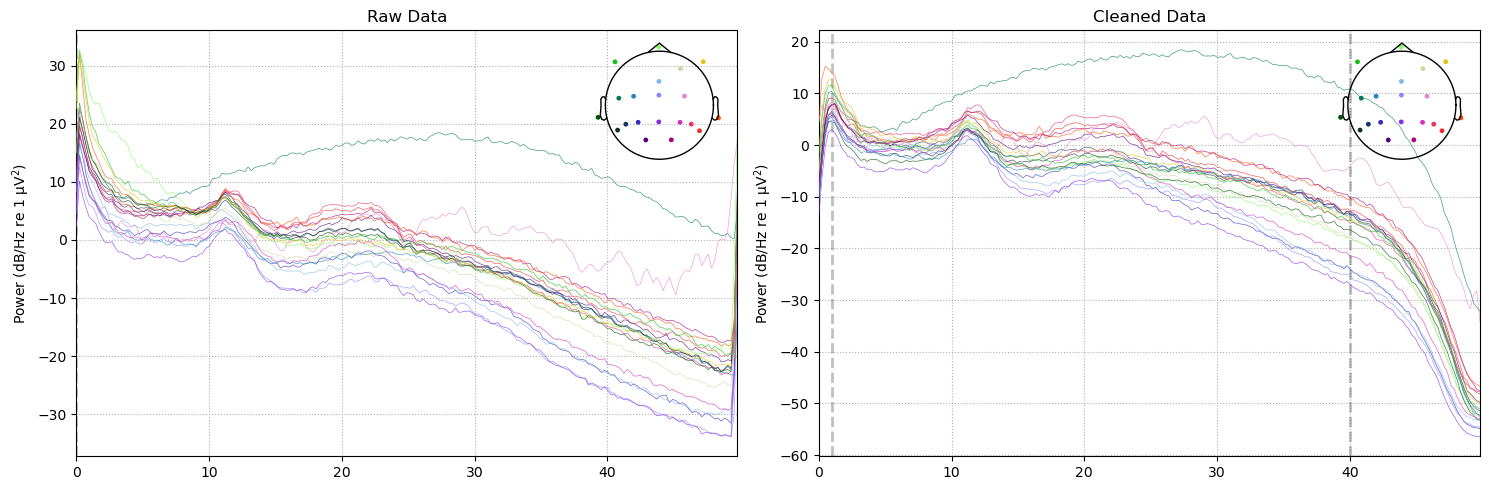

In [43]:
# compare psd before and after cleaning
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# raw
raw_data.plot_psd(fmax=50, ax=axes[0], show=False)
axes[0].set_title('Raw Data')
# clean
raw_data_clean.plot_psd(fmax=50, ax=axes[1], show=False)
axes[1].set_title('Cleaned Data')
plt.tight_layout()
plt.show()


## 6. Epoching (sample code)

Segment the continuous data into epochs based on stimulus markers (s1000, s1050).


In [23]:
# Extract events from annotations
# The BrainVision files have annotations with stimulus markers
print("=== Extracting Events ===")
print(f"Classical annotations: {len(raw_classical_clean.annotations)}")
print(f"Rock annotations: {len(raw_rock_clean.annotations)}")

# Show available event types
print(f"\nClassical event types: {set(raw_classical_clean.annotations.description)}")
print(f"Rock event types: {set(raw_rock_clean.annotations.description)}")

# Convert annotations to events
events_classical, event_id_classical = mne.events_from_annotations(
    raw_classical_clean, 
    event_id=None,  # Use all events
    regexp='Stimulus/s.*'  # Only get stimulus events (s1000, s1050, etc.)
)

events_rock, event_id_rock = mne.events_from_annotations(
    raw_rock_clean,
    event_id=None,
    regexp='Stimulus/s.*'
)

print(f"\n✓ Found {len(events_classical)} events in Classical data")
print(f"  Event IDs: {event_id_classical}")
print(f"✓ Found {len(events_rock)} events in Rock data")
print(f"  Event IDs: {event_id_rock}")


=== Extracting Events ===
Classical annotations: 12
Rock annotations: 13

Classical event types: {np.str_('Marker/Impedance'), np.str_('Stimulus/s1050'), np.str_('New Segment/'), np.str_('Stimulus/s1000')}
Rock event types: {np.str_('Marker/Impedance'), np.str_('Stimulus/s1050'), np.str_('New Segment/')}
Used Annotations descriptions: [np.str_('Stimulus/s1000'), np.str_('Stimulus/s1050')]
Used Annotations descriptions: [np.str_('Stimulus/s1050')]

✓ Found 7 events in Classical data
  Event IDs: {np.str_('Stimulus/s1000'): 1, np.str_('Stimulus/s1050'): 2}
✓ Found 8 events in Rock data
  Event IDs: {np.str_('Stimulus/s1050'): 1}


In [24]:
# Create epochs around stimulus events
# Epoch window: -0.5 seconds before to 2.0 seconds after stimulus onset
tmin = -0.5  # Start 0.5 seconds before event
tmax = 2.0   # End 2.0 seconds after event
baseline = (None, 0)  # Baseline correction from start of epoch to event onset

print("Creating epochs...")
epochs_classical = mne.Epochs(
    raw_classical_clean,
    events_classical,
    event_id=event_id_classical,
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    preload=True,
    reject_by_annotation=True  # Reject epochs with bad annotations
)

epochs_rock = mne.Epochs(
    raw_rock_clean,
    events_rock,
    event_id=event_id_rock,
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    preload=True,
    reject_by_annotation=True
)

print(f"✓ Created {len(epochs_classical)} epochs for Classical data")
print(f"✓ Created {len(epochs_rock)} epochs for Rock data")
print(f"\nEpoch duration: {tmax - tmin} seconds ({tmin} to {tmax} seconds around event)")


Creating epochs...
Not setting metadata
7 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 7 events and 1251 original time points ...
0 bad epochs dropped
Not setting metadata
8 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 8 events and 1251 original time points ...
0 bad epochs dropped
✓ Created 7 epochs for Classical data
✓ Created 8 epochs for Rock data

Epoch duration: 2.5 seconds (-0.5 to 2.0 seconds around event)


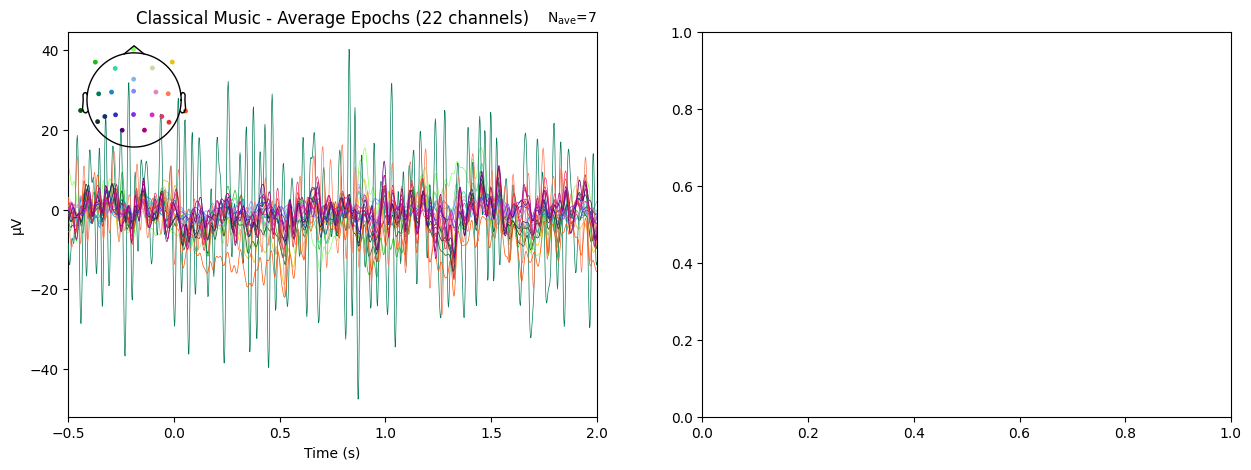

<Figure size 640x480 with 0 Axes>

In [25]:
# Visualize epochs
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot average across all epochs
epochs_classical.average().plot(axes=axes[0], titles='Classical Music - Average Epochs')
epochs_rock.average().plot(axes=axes[1], titles='Rock Music - Average Epochs')

plt.tight_layout()
plt.show()


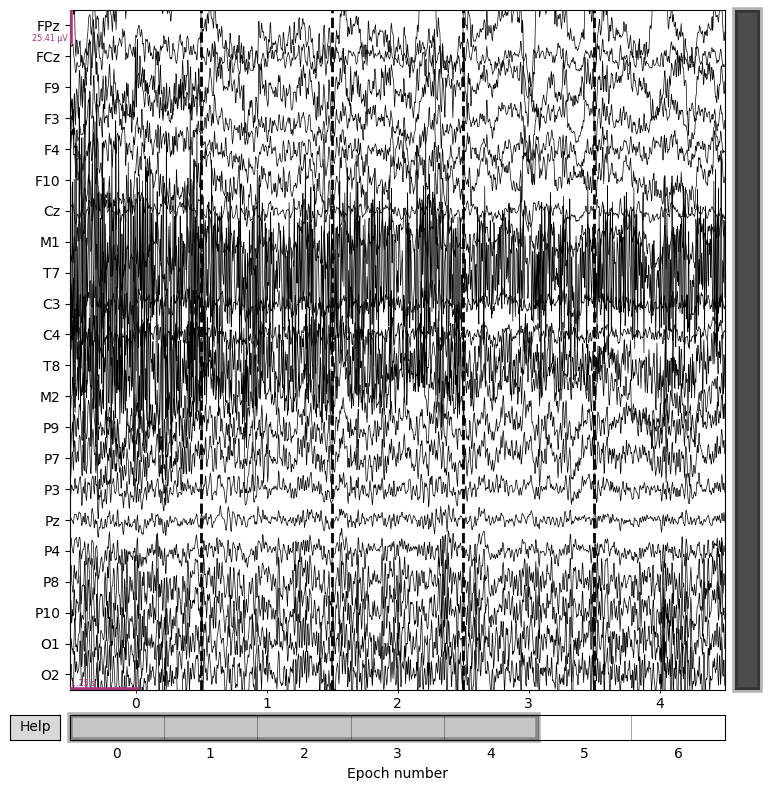

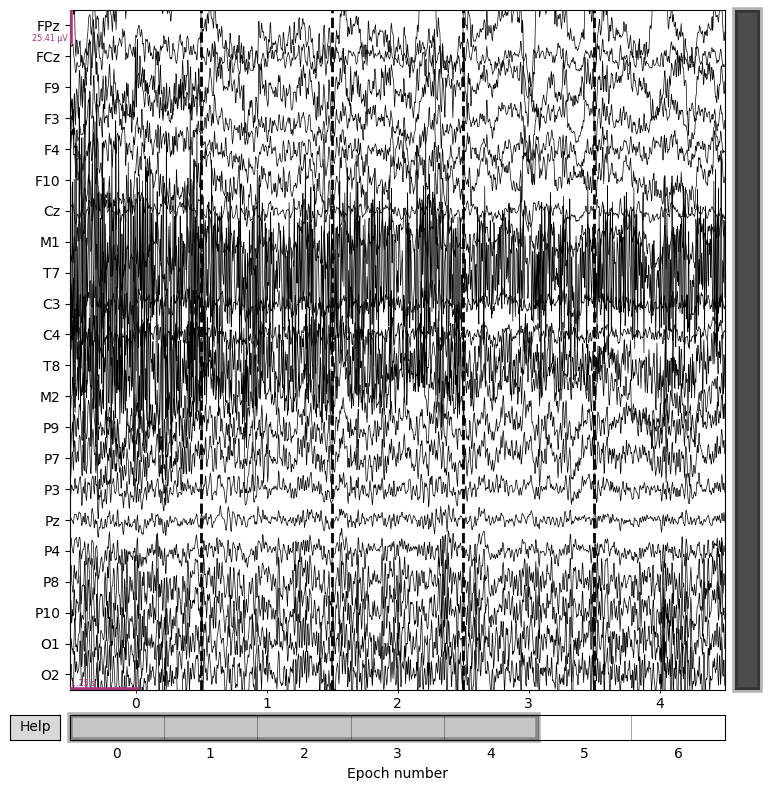

In [26]:
# Plot individual epochs to check data quality
epochs_classical.plot(n_epochs=5, n_channels=22, scalings='auto', title='Classical - Sample Epochs')


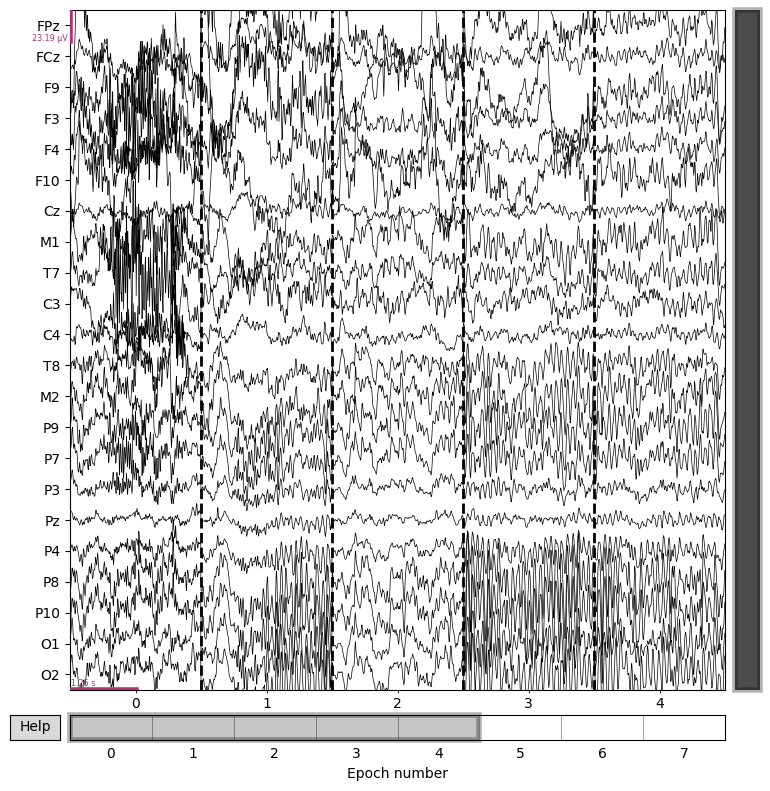

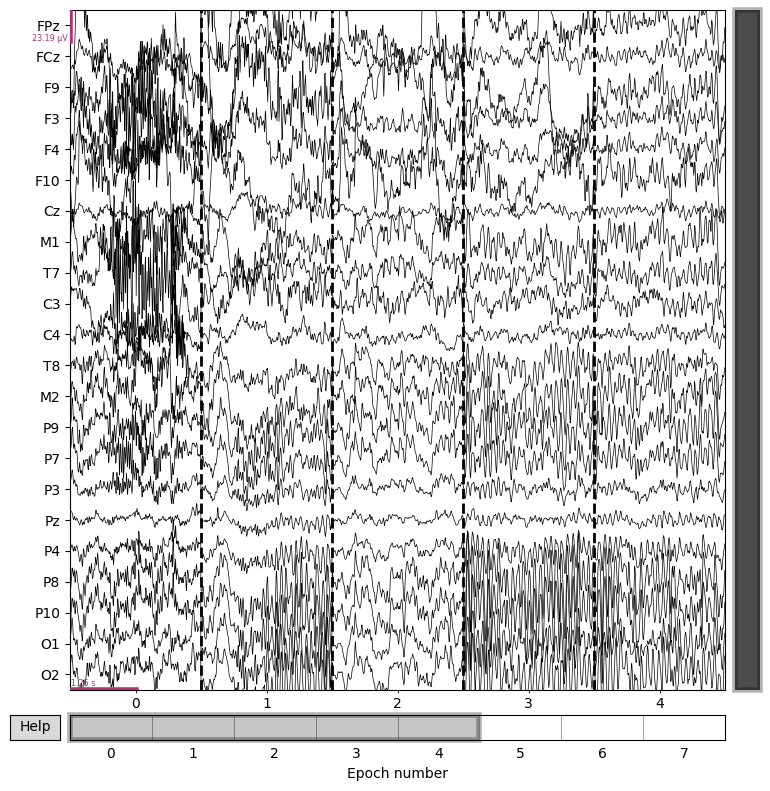

In [27]:
epochs_rock.plot(n_epochs=5, n_channels=22, scalings='auto', title='Rock - Sample Epochs')


## 7. Power Analysis (Alpha & Theta) (sample code)

Extract power in alpha (8-13 Hz) and theta (4-8 Hz) frequency bands and compare between conditions.

In [28]:
# Compute PSD for Classical epochs
# Let MNE choose optimal parameters based on epoch length
psd_classical = epochs_classical.compute_psd(
    method='welch',
    fmin=1.0,
    fmax=40.0
    # Don't specify n_fft - MNE will choose appropriate value
)

# Compute PSD for Rock epochs
psd_rock = epochs_rock.compute_psd(
    method='welch',
    fmin=1.0,
    fmax=40.0
)

Effective window size : 2.502 (s)
Effective window size : 2.502 (s)


Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


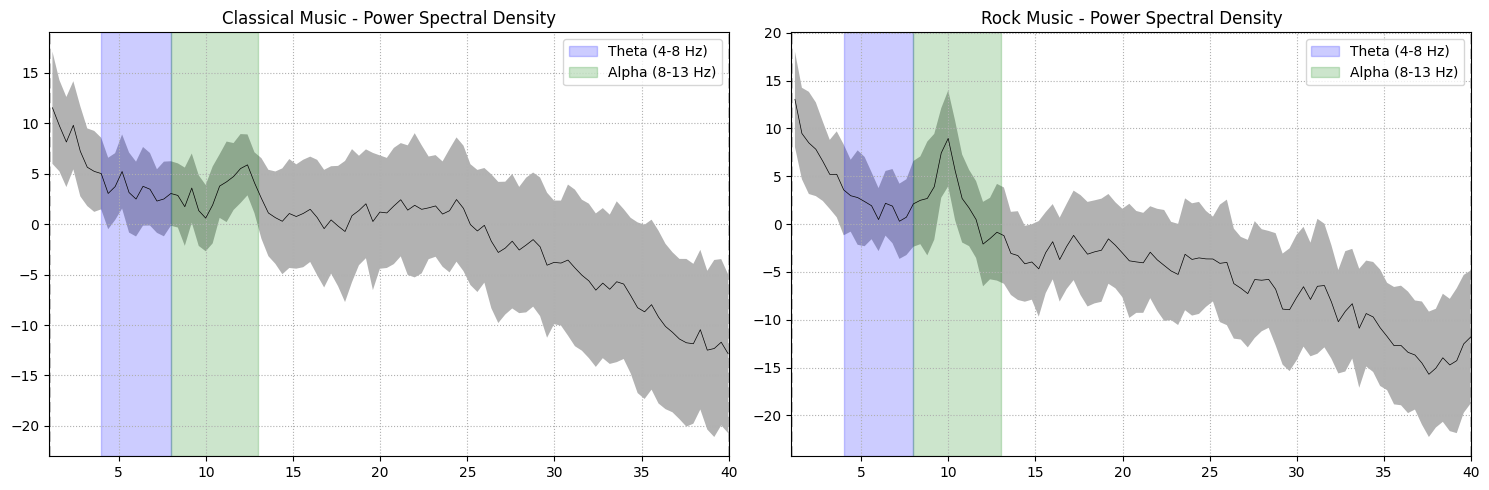

In [29]:
# Visualize power spectral density
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

psd_classical.plot(average=True, axes=axes[0], show=False, picks='eeg')
axes[0].set_title('Classical Music - Power Spectral Density')
axes[0].axvspan(4, 8, alpha=0.2, color='blue', label='Theta (4-8 Hz)')
axes[0].axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
axes[0].legend()
axes[0].set_xlim(1, 40)

psd_rock.plot(average=True, axes=axes[1], show=False, picks='eeg')
axes[1].set_title('Rock Music - Power Spectral Density')
axes[1].axvspan(4, 8, alpha=0.2, color='blue', label='Theta (4-8 Hz)')
axes[1].axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
axes[1].legend()
axes[1].set_xlim(1, 40)

plt.tight_layout()
plt.show()


In [30]:
# Extract power in specific frequency bands
# Define frequency bands
freq_bands = {
    'theta': (4, 8),   # Theta: 4-8 Hz
    'alpha': (8, 13),  # Alpha: 8-13 Hz
    'beta': (13, 30),  # Beta: 13-30 Hz (bonus)
    'delta': (1, 4)    # Delta: 1-4 Hz (bonus)
}

# Get PSD data
psd_data_classical = psd_classical.get_data()  # Shape: (n_epochs, n_channels, n_freqs)
psd_data_rock = psd_rock.get_data()

freqs_classical = psd_classical.freqs
freqs_rock = psd_rock.freqs

print("Extracting band power...")

# Function to extract band power
def extract_band_power(psd_data, freqs, band_name, fmin, fmax):
    """Extract average power in a frequency band"""
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    band_power = psd_data[:, :, freq_mask].mean(axis=2)  # Average across frequencies
    return band_power

# Extract band power for each condition
band_power_classical = {}
band_power_rock = {}

for band_name, (fmin, fmax) in freq_bands.items():
    band_power_classical[band_name] = extract_band_power(
        psd_data_classical, freqs_classical, band_name, fmin, fmax
    )
    band_power_rock[band_name] = extract_band_power(
        psd_data_rock, freqs_rock, band_name, fmin, fmax
    )
    print(f"✓ {band_name.capitalize()} ({fmin}-{fmax} Hz): "
          f"Classical shape {band_power_classical[band_name].shape}, "
          f"Rock shape {band_power_rock[band_name].shape}")

print("\n✓ Band power extraction complete")


Extracting band power...
✓ Theta (4-8 Hz): Classical shape (7, 22), Rock shape (8, 22)
✓ Alpha (8-13 Hz): Classical shape (7, 22), Rock shape (8, 22)
✓ Beta (13-30 Hz): Classical shape (7, 22), Rock shape (8, 22)
✓ Delta (1-4 Hz): Classical shape (7, 22), Rock shape (8, 22)

✓ Band power extraction complete


In [31]:
# Compute average power across epochs and channels for each band
print("\n=== Average Band Power (across all epochs and channels) ===")
for band_name in ['theta', 'alpha']:
    classical_avg = band_power_classical[band_name].mean()
    rock_avg = band_power_rock[band_name].mean()
    diff = rock_avg - classical_avg
    diff_pct = (diff / classical_avg) * 100
    
    print(f"\n{band_name.capitalize()} Band ({freq_bands[band_name][0]}-{freq_bands[band_name][1]} Hz):")
    print(f"  Classical: {classical_avg:.4f} (arbitrary units)")
    print(f"  Rock:       {rock_avg:.4f} (arbitrary units)")
    print(f"  Difference: {diff:.4f} ({diff_pct:+.1f}%)")



=== Average Band Power (across all epochs and channels) ===

Theta Band (4-8 Hz):
  Classical: 0.0000 (arbitrary units)
  Rock:       0.0000 (arbitrary units)
  Difference: -0.0000 (-24.8%)

Alpha Band (8-13 Hz):
  Classical: 0.0000 (arbitrary units)
  Rock:       0.0000 (arbitrary units)
  Difference: 0.0000 (+58.3%)


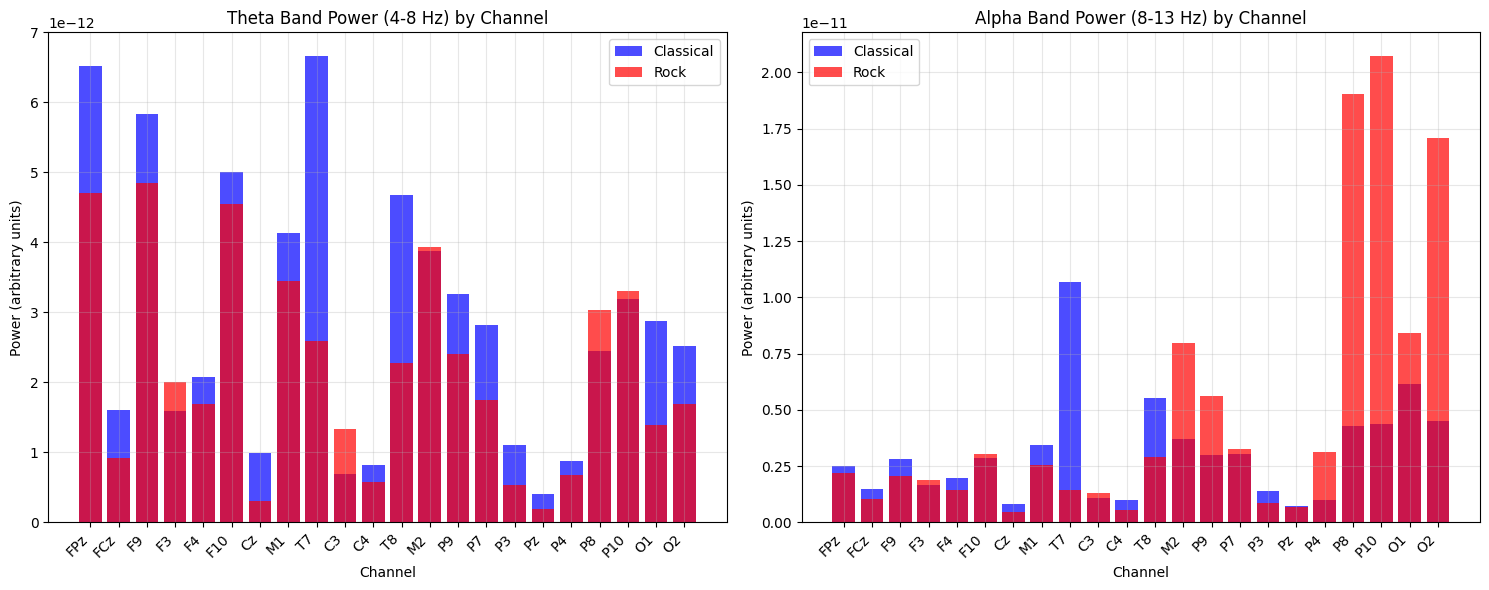

In [32]:
# Visualize band power comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Theta power comparison
theta_classical = band_power_classical['theta'].mean(axis=0)  # Average across epochs
theta_rock = band_power_rock['theta'].mean(axis=0)

axes[0].bar(range(len(theta_classical)), theta_classical, alpha=0.7, label='Classical', color='blue')
axes[0].bar(range(len(theta_rock)), theta_rock, alpha=0.7, label='Rock', color='red')
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('Power (arbitrary units)')
axes[0].set_title('Theta Band Power (4-8 Hz) by Channel')
axes[0].set_xticks(range(len(epochs_classical.ch_names)))
axes[0].set_xticklabels(epochs_classical.ch_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Alpha power comparison
alpha_classical = band_power_classical['alpha'].mean(axis=0)  # Average across epochs
alpha_rock = band_power_rock['alpha'].mean(axis=0)

axes[1].bar(range(len(alpha_classical)), alpha_classical, alpha=0.7, label='Classical', color='blue')
axes[1].bar(range(len(alpha_rock)), alpha_rock, alpha=0.7, label='Rock', color='red')
axes[1].set_xlabel('Channel')
axes[1].set_ylabel('Power (arbitrary units)')
axes[1].set_title('Alpha Band Power (8-13 Hz) by Channel')
axes[1].set_xticks(range(len(epochs_classical.ch_names)))
axes[1].set_xticklabels(epochs_classical.ch_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


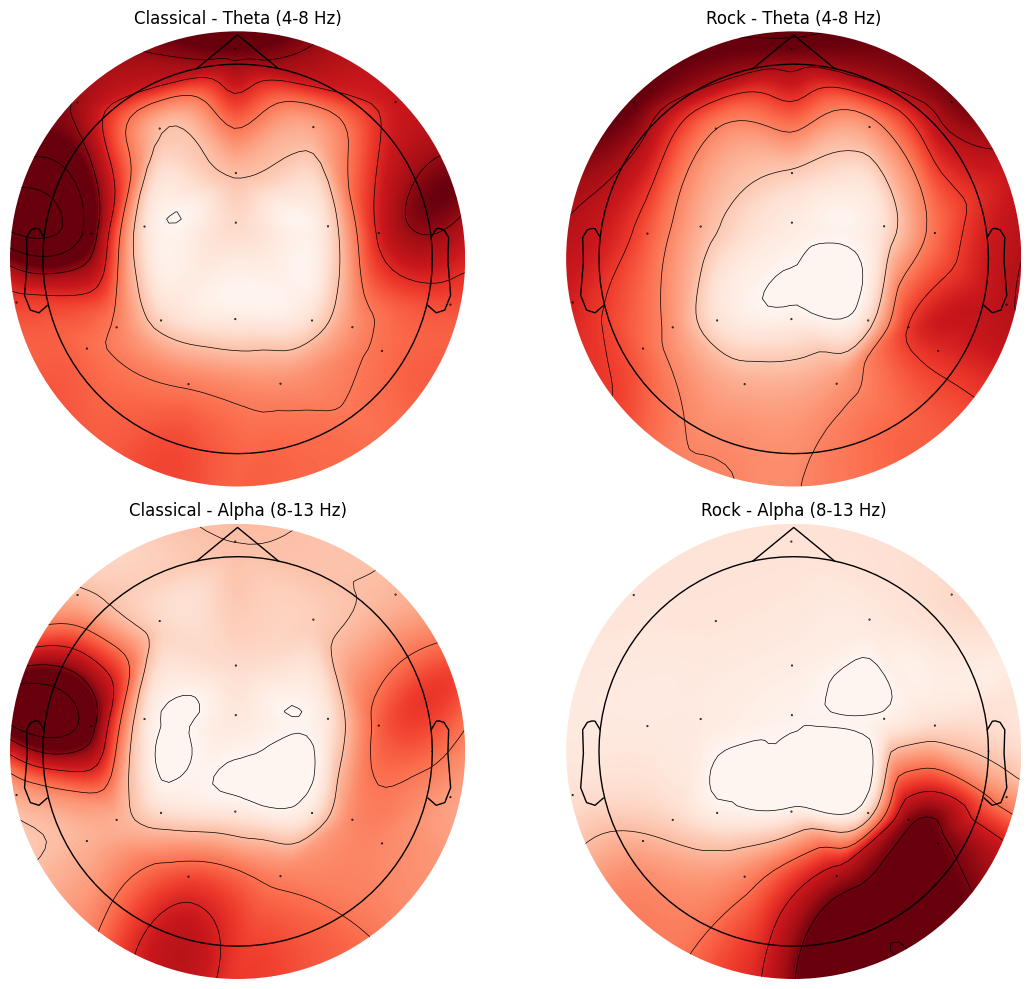

In [34]:
# Topographic maps of band power
# Create average power across epochs for visualization
theta_classical_avg = band_power_classical['theta'].mean(axis=0)
alpha_classical_avg = band_power_classical['alpha'].mean(axis=0)
theta_rock_avg = band_power_rock['theta'].mean(axis=0)
alpha_rock_avg = band_power_rock['alpha'].mean(axis=0)

# Create evoked objects for topomap plotting
# We'll use the average of epochs as a template
evoked_classical = epochs_classical.average()
evoked_rock = epochs_rock.average()

# Create topomaps
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Theta - Classical
mne.viz.plot_topomap(
    theta_classical_avg, 
    evoked_classical.info, 
    axes=axes[0, 0],
    show=False
)
axes[0, 0].set_title('Classical - Theta (4-8 Hz)')

# Theta - Rock
mne.viz.plot_topomap(
    theta_rock_avg,
    evoked_rock.info,
    axes=axes[0, 1],
    show=False
)
axes[0, 1].set_title('Rock - Theta (4-8 Hz)')

# Alpha - Classical
mne.viz.plot_topomap(
    alpha_classical_avg,
    evoked_classical.info,
    axes=axes[1, 0],
    show=False
)
axes[1, 0].set_title('Classical - Alpha (8-13 Hz)')

# Alpha - Rock
mne.viz.plot_topomap(
    alpha_rock_avg,
    evoked_rock.info,
    axes=axes[1, 1],
    show=False
)
axes[1, 1].set_title('Rock - Alpha (8-13 Hz)')

plt.tight_layout()
plt.show()

In [35]:
# Summary statistics by brain region
# Group channels by brain region
frontal_channels = ['FPz', 'F9', 'F3', 'F4', 'F10', 'FCz']
central_channels = ['Cz', 'C3', 'C4']
temporal_channels = ['T7', 'T8']
parietal_channels = ['P9', 'P7', 'P3', 'Pz', 'P4', 'P8', 'P10']
occipital_channels = ['O1', 'O2']

def get_region_power(band_power, channel_names, region_channels):
    """Get average power for a brain region"""
    region_indices = [i for i, ch in enumerate(channel_names) if ch in region_channels]
    if len(region_indices) == 0:
        return None
    return band_power[:, region_indices].mean(axis=1).mean()  # Average across epochs and channels

print("\n=== Band Power by Brain Region ===")
regions = {
    'Frontal': frontal_channels,
    'Central': central_channels,
    'Temporal': temporal_channels,
    'Parietal': parietal_channels,
    'Occipital': occipital_channels
}

for region_name, region_chs in regions.items():
    print(f"\n{region_name}:")
    for band_name in ['theta', 'alpha']:
        classical_power = get_region_power(
            band_power_classical[band_name], 
            epochs_classical.ch_names, 
            region_chs
        )
        rock_power = get_region_power(
            band_power_rock[band_name],
            epochs_rock.ch_names,
            region_chs
        )
        if classical_power is not None and rock_power is not None:
            diff_pct = ((rock_power - classical_power) / classical_power) * 100
            print(f"  {band_name.capitalize()}: Classical={classical_power:.4f}, "
                  f"Rock={rock_power:.4f} ({diff_pct:+.1f}%)")



=== Band Power by Brain Region ===

Frontal:
  Theta: Classical=0.0000, Rock=0.0000 (-17.3%)
  Alpha: Classical=0.0000, Rock=0.0000 (-12.6%)

Central:
  Theta: Classical=0.0000, Rock=0.0000 (-11.3%)
  Alpha: Classical=0.0000, Rock=0.0000 (-20.0%)

Temporal:
  Theta: Classical=0.0000, Rock=0.0000 (-57.1%)
  Alpha: Classical=0.0000, Rock=0.0000 (-73.1%)

Parietal:
  Theta: Classical=0.0000, Rock=0.0000 (-15.8%)
  Alpha: Classical=0.0000, Rock=0.0000 (+199.6%)

Occipital:
  Theta: Classical=0.0000, Rock=0.0000 (-43.1%)
  Alpha: Classical=0.0000, Rock=0.0000 (+139.6%)
